In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from anime_background_gan import Transformer


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# https://huggingface.co/akiyamasho/AnimeBackgroundGAN-Miyazaki
model = Transformer().to(device)
model.load_state_dict(torch.load("miyazaki_hayao.pth"))
print(model)


cuda
Transformer(
  (refpad01_1): ReflectionPad2d((3, 3, 3, 3))
  (conv01_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (in01_1): InstanceNormalization()
  (conv02_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv02_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in02_1): InstanceNormalization()
  (conv03_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv03_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in03_1): InstanceNormalization()
  (refpad04_1): ReflectionPad2d((1, 1, 1, 1))
  (conv04_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (in04_1): InstanceNormalization()
  (refpad04_2): ReflectionPad2d((1, 1, 1, 1))
  (conv04_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (in04_2): InstanceNormalization()
  (refpad05_1): ReflectionPad2d((1, 1, 1, 1))
  (conv05_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (in05_1): InstanceNormalizat

torch.Size([1, 3, 375, 500])
0.61618143 0.2336023


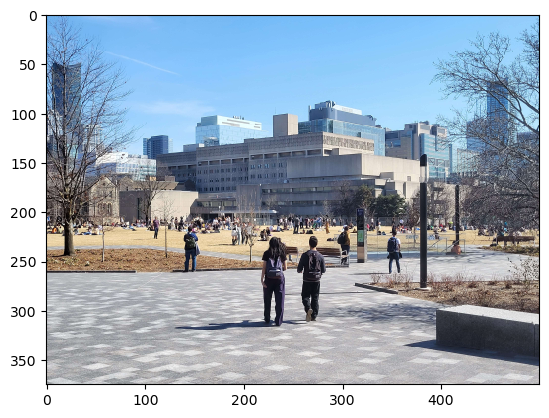

0.4476195759998518
torch.Size([1, 3, 375, 500])
0.52231777 0.21984309


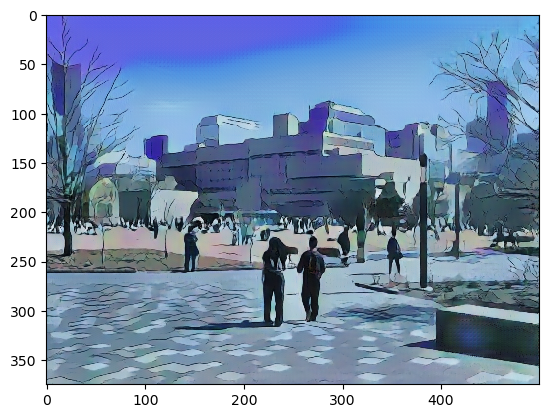

In [2]:
def plot_frame(frame):
    print(frame.shape)
    frame = frame[0].cpu().numpy()
    print(np.mean(frame), np.std(frame))
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', frame)
    plt.figure()
    plt.imshow(frame)
    plt.show()


from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1217540783788527696-20240313_143132.jpg"
# filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1215771448753389759-20240308_150538.jpg"
# filename = "noisy.png"
image = Image.open(filename).convert("RGB")
image = pil_to_tensor(image).unsqueeze(0).to(device)/255
n = int((image.numel() / (600*400*3))**0.5 + 1)
if n > 1:
    image = F.avg_pool2d(image, n)

x = image
plot_frame(x)

from time import perf_counter
with torch.no_grad():
    y = model(x)
    t0 = perf_counter()
    for i in range(10):
        y = model(2*x-1)*0.5+0.5
    t1 = perf_counter()
    print(t1-t0)
y = y[:,:,:x.shape[2],:x.shape[3]]
plot_frame(y)


tensor([1.2104, 1.1518, 1.1345], device='cuda:0')
tensor([ 0.0598,  0.0267, -0.0554], device='cuda:0')
torch.Size([1, 3, 375, 500])
0.6161812 0.2336023


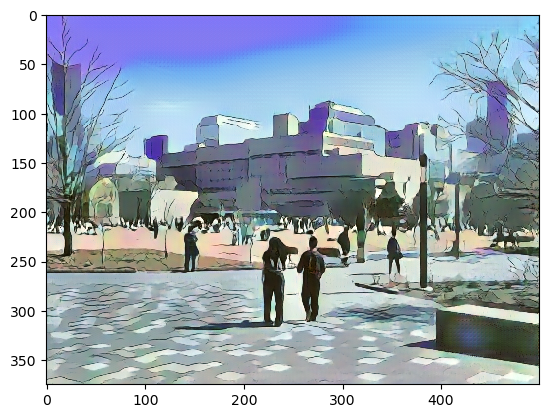

In [3]:
def get_ms_1(x):
    u = torch.mean(x, (2, 3)).reshape((len(x), 3, 1, 1))
    s = torch.std(x, (2, 3)).reshape((len(x), 3, 1, 1))
    return u, s

ux, sx = get_ms_1(x)
uy, sy = get_ms_1(y)

w = sx/sy
b = ux-w*uy
print(w.squeeze())
print(b.squeeze())

y1 = w * y + b

plot_frame(y1)


torch.Size([1, 3, 375, 500]) torch.Size([1, 3, 375, 500])
torch.Size([1, 3, 3]) torch.Size([3])
tensor([[[ 0.8065,  0.3014, -0.0844],
         [ 0.1351,  0.3313,  0.5565],
         [-0.4219,  0.2470,  1.1015]]], device='cuda:0')
tensor([0.1247, 0.0308, 0.0113], device='cuda:0')
torch.Size([1, 3, 375, 500])
0.6161812 0.21220867


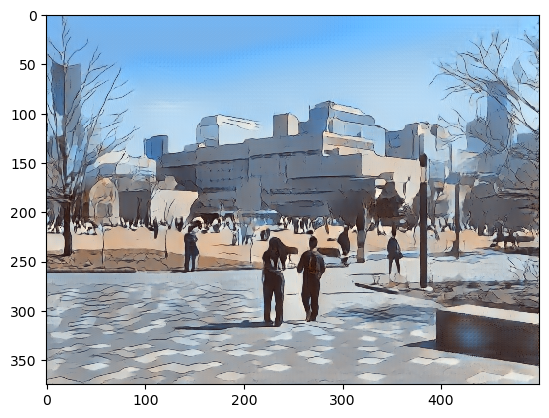

In [4]:
def compute_W_and_B(batch1, batch2):
    # Reshape batches to (batch_size, num_channels, num_pixels)
    batch1 = batch1.view(batch1.size(0), batch1.size(1), -1)
    batch2 = batch2.view(batch2.size(0), batch2.size(1), -1)
    
    # Compute means of the batches
    mean_batch1 = torch.mean(batch1, dim=2, keepdim=True)
    mean_batch2 = torch.mean(batch2, dim=2, keepdim=True)
    
    # Compute centered batches
    centered_batch1 = batch1 - mean_batch1
    centered_batch2 = batch2 - mean_batch2
    
    # Compute covariance matrix
    xTy = torch.matmul(centered_batch1, centered_batch2.transpose(1, 2))
    xTx = torch.matmul(centered_batch1, centered_batch1.transpose(1, 2))
    
    # Compute weight matrix
    W = torch.matmul(torch.linalg.inv(xTx), xTy)
    W = W.transpose(1, 2)

    # Compute bias vector
    B = mean_batch2.squeeze() - torch.matmul(W, mean_batch1).squeeze()

    return W, B

print(x.shape, y.shape)
W, B = compute_W_and_B(y, x)

print(W.shape, B.shape)
print(W)
print(B)

y2 = torch.matmul(W, y.reshape(1, 3, -1)).view_as(y) + B.reshape(y.shape[0], y.shape[1], 1, 1)

plot_frame(y2)
